

## **Analysis of CROCO simulations for the Humboldt current system**. 
### Improvements of NCCHILE/Orlando simulation - Experiment (3): Fixed crocotools interpolation. True ERA5 Drop-off

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmaps
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cf
import datetime
import geopandas as gpd
import xesmf as xe
import glob
import regionmask
import xgcm
import dask
import os
from dask.diagnostics import ProgressBar

plt.rc('font', size=16)
plt.rc('font', size=16)

In [2]:
#Load grid data
coastmask   = gpd.read_file('~/storage/VECTORIAL/limites/ChileCOASTMASK.shp')
coastline   = gpd.read_file('~/storage/VECTORIAL/limites/lnealitoral/lineadecosta.shp')

#My model
grid = xr.open_dataset('data/CROCO/OUTPUT/TESTSIM/24HERA5_GLORYS12V1/testsim_grd.nc').squeeze().load()
grid = grid[['h','xi_rho','eta_rho','lon_rho','lat_rho','x_rho','y_rho','mask_rho']]
grid['lon_rho'] = (grid.lon_rho+180)%360-180
grid

<xarray.Dataset>
Dimensions:   (eta_rho: 294, xi_rho: 325)
Coordinates:
  * xi_rho    (xi_rho) int64 0 1 2 3 4 5 6 7 ... 317 318 319 320 321 322 323 324
  * eta_rho   (eta_rho) int64 0 1 2 3 4 5 6 7 ... 287 288 289 290 291 292 293
Data variables:
    h         (eta_rho, xi_rho) float32 433.6 433.6 450.8 ... 10.0 10.0 10.0
    lon_rho   (eta_rho, xi_rho) float32 -79.0 -78.97 -78.94 ... -70.03 -70.0
    lat_rho   (eta_rho, xi_rho) float32 -34.0 -34.0 -34.0 ... -27.0 -27.0 -27.0
    x_rho     (eta_rho, xi_rho) float32 -0.03125 2.557e+03 ... 8.912e+05
    y_rho     (eta_rho, xi_rho) float32 -0.03125 -0.03125 ... 7.784e+05
    mask_rho  (eta_rho, xi_rho) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:                     North-Central Chile
    date:                      05-Dec-2022
    type:                      CROCO grid file
    history:                   Fri Jan 27 13:40:48 2023: ncpdq -L 5 -7 backup...
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    nco_openmp_thread_number:  1

In [3]:
#Load OSTIA reference dataset:
if os.path.exists('data/ZARR/ostia'):
    ostia = xr.open_zarr('data/ZARR/ostia').chunk({'time':1})
    ostia = ostia.chunk({'lat':len(ostia.lat),'lon':len(ostia.lon)})
else:
    raise FileNotFoundError('zarr store doesnt exists!')

ostia_clim = xr.open_dataset('~/storage/SST_CLIMATOLOGY_OSTIA.nc').rename({'analysed_sst':'sst'})

In [4]:
#Load testsim control dataset: 
if os.path.exists('data/ZARR/testsim_control'):
    testsim_control = xr.open_zarr('data/ZARR/testsim_control').chunk({'time':1,'s_rho':50})
else:
    raise FileExistsError('zarr store doesnt exists!')

testsim_control['lon_rho'] = testsim_control.lon_rho.load()
testsim_control['lat_rho'] = testsim_control.lat_rho.load()

In [5]:
#Load GLORYS12V1 dataset:
if os.path.exists('data/ZARR/glorys12v1/'):
    glorys = xr.open_zarr('data/ZARR/glorys12v1/').chunk({'time':1})
    glorys = glorys.chunk({'lat':len(ostia.lat),'lon':len(ostia.lon),'depth':len(glorys.depth)})
else:
    raise FileNotFoundError('zarr store doesnt exists!')


glorys = glorys.sel(lat=slice(-35,-26.5), lon=slice(-80,-69)).chunk({'lat':len(ostia.lat),'lon':len(ostia.lon)})
glorys

<xarray.Dataset>
Dimensions:  (depth: 50, lat: 103, lon: 133, time: 640)
Coordinates:
  * depth    (depth) float64 0.494 1.541 2.646 ... 4.833e+03 5.275e+03 5.728e+03
  * lat      (lat) float64 -35.0 -34.92 -34.83 -34.75 ... -26.67 -26.58 -26.5
  * lon      (lon) float64 -80.0 -79.92 -79.83 -79.75 ... -69.17 -69.08 -69.0
  * time     (time) datetime64[ns] 2006-04-01 2006-04-02 ... 2007-12-31
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 103, 133), meta=np.ndarray>
    temp     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 50, 103, 133), meta=np.ndarray>
    vo       (time, depth, lat, lon) float32 dask.array<chunksize=(1, 50, 103, 133), meta=np.ndarray>

In [6]:
#Load testsim BLKNOMASK dataset: 
if os.path.exists('data/ZARR/testsim_BLKNOMASK'):
    testsim_BLKNOMASK = xr.open_zarr('data/ZARR/testsim_BLKNOMASK').chunk({'time':1,'s_rho':50})
else:
    raise FileExistsError('zarr store doesnt exists!')

testsim_BLKNOMASK['lon_rho'] = testsim_BLKNOMASK.lon_rho.load()
testsim_BLKNOMASK['lat_rho'] = testsim_BLKNOMASK.lat_rho.load()

In [7]:
#Target dates for the analysis !
ttime = pd.date_range('2006-04','2008', freq='d')[:-1]

In [8]:
#Interpolate horizontal grids
with ProgressBar():
    reference       = ostia.reindex({'time':ttime},method='nearest')
    clim            = ostia_clim.reindex({'lat':reference.lat.values,'lon':reference.lon.values})
    husk            = xr.Dataset(coords={'lat':(['lat'], reference.lat.values, reference.lat.attrs),
                                        'lon':(['lon'], reference.lon.values, reference.lon.attrs)})


    regridder        = xe.Regridder(glorys, reference, 'bilinear')
    glorys_bias      = regridder(glorys['sst'].reindex({'time':ttime},method='nearest'))
    glorys_corr      = xr.corr(glorys_bias, reference.sst, dim='time')
    glorys_acorr     = xr.corr(glorys_bias.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst,
                            reference.sst.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst, dim='time').load()
    glorys_bias      = glorys_bias-reference.sst


    regridder       = xe.Regridder(testsim_control.rename({'lat_rho':'lat','lon_rho':'lon'}), reference, 'bilinear')
    testsim_control_bias    = regridder(testsim_control['sst'].rename({'lat_rho':'lat','lon_rho':'lon'}).chunk({'eta_rho':len(testsim_control.eta_rho),'xi_rho':len(testsim_control.xi_rho)}))
    testsim_control_bias    = testsim_control_bias.where(testsim_control_bias>0).reindex({'time':ttime},method='nearest')
    testsim_control_corr    = xr.corr(testsim_control_bias, reference.sst, dim='time').load()
    testsim_control_acorr   = xr.corr(testsim_control_bias.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst,
                                      reference.sst.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst, dim='time').load()
    testsim_control_bias    = (testsim_control_bias-reference.sst).load()


    regridder       = xe.Regridder(testsim_BLKNOMASK.rename({'lat_rho':'lat','lon_rho':'lon'}), reference, 'bilinear')
    testsim_BLKNOMASK_bias    = regridder(testsim_BLKNOMASK['sst'].rename({'lat_rho':'lat','lon_rho':'lon'}).chunk({'eta_rho':len(testsim_BLKNOMASK.eta_rho),'xi_rho':len(testsim_BLKNOMASK.xi_rho)}))
    testsim_BLKNOMASK_bias    = testsim_BLKNOMASK_bias.where(testsim_BLKNOMASK_bias>0).reindex({'time':ttime},method='nearest')
    testsim_BLKNOMASK_corr    = xr.corr(testsim_BLKNOMASK_bias, reference.sst, dim='time').load()
    testsim_BLKNOMASK_acorr   = xr.corr(testsim_BLKNOMASK_bias.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst,
                                 reference.sst.convert_calendar('noleap').groupby('time.dayofyear')-clim.sst, dim='time').load()
    testsim_BLKNOMASK_bias    = (testsim_BLKNOMASK_bias-reference.sst).load()



[######################################  ] | 95% Completed | 72.60 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 76.78 s
[####################################    ] | 91% Completed | 43.32 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 47.39 s
[#####################################   ] | 92% Completed | 51.15 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 55.10 s
[########################################] | 100% Completed | 30.54 s
[####################################    ] | 91% Completed | 43.21 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 47.07 s
[#####################################   ] | 92% Completed | 50.83 ss

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 54.87 s
[########################################] | 100% Completed | 30.05 s


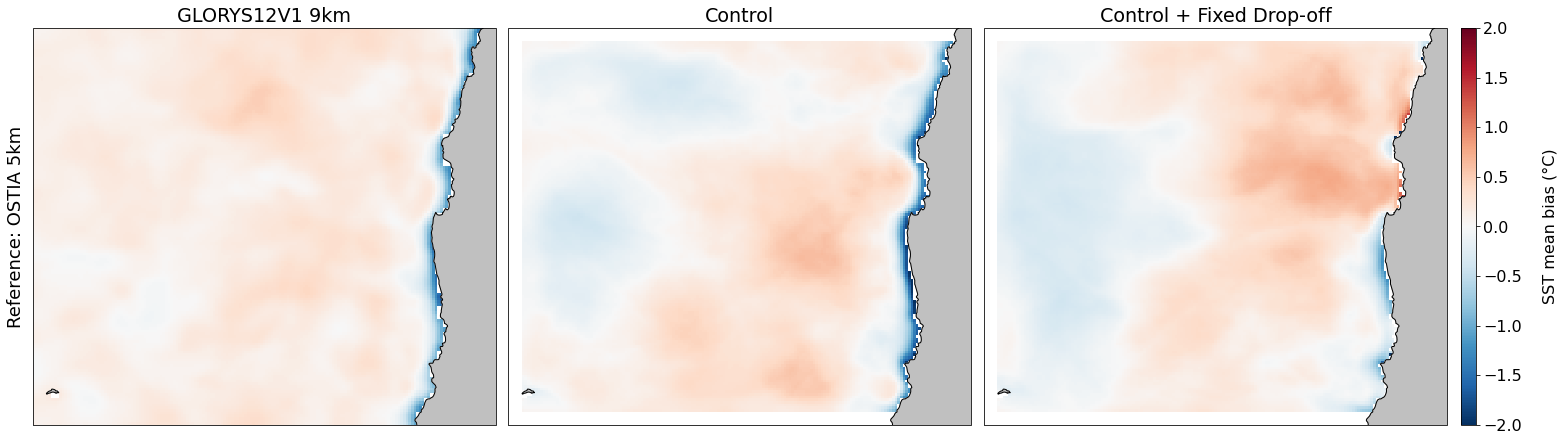

In [10]:
fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
fig.tight_layout(pad=0.8)
titles    = ['GLORYS12V1 9km','Control','Control + Fixed Drop-off']
plt.rc('font', size=16)
for i,axis in enumerate(ax):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines(zorder=3)
    axis.add_feature(cf.LAND, zorder=2, color='silver')
    axis.set_title(titles[i])
ax[0].set_yticks([])
ax[0].set_ylabel('Reference: OSTIA 5km', fontsize=18)
box = ax[-1].get_position()
cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

cmap='RdBu_r'
norm=mcolors.Normalize(-2,2)

m=ax[0].pcolormesh(glorys_bias.lon,glorys_bias.lat, glorys_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
m=ax[1].pcolormesh(testsim_control_bias.lon,testsim_control_bias.lat, testsim_control_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
m=ax[2].pcolormesh(testsim_BLKNOMASK_bias.lon,testsim_BLKNOMASK_bias.lat, testsim_BLKNOMASK_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
# ax[1].pcolormesh(ncchile_bias.lon,ncchile_bias.lat, ncchile_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
# ax[2].pcolormesh(simulation_bias.lon,simulation_bias.lat, simulation_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
fig.colorbar(m,cax=cax, label='\nSST mean bias (°C)')

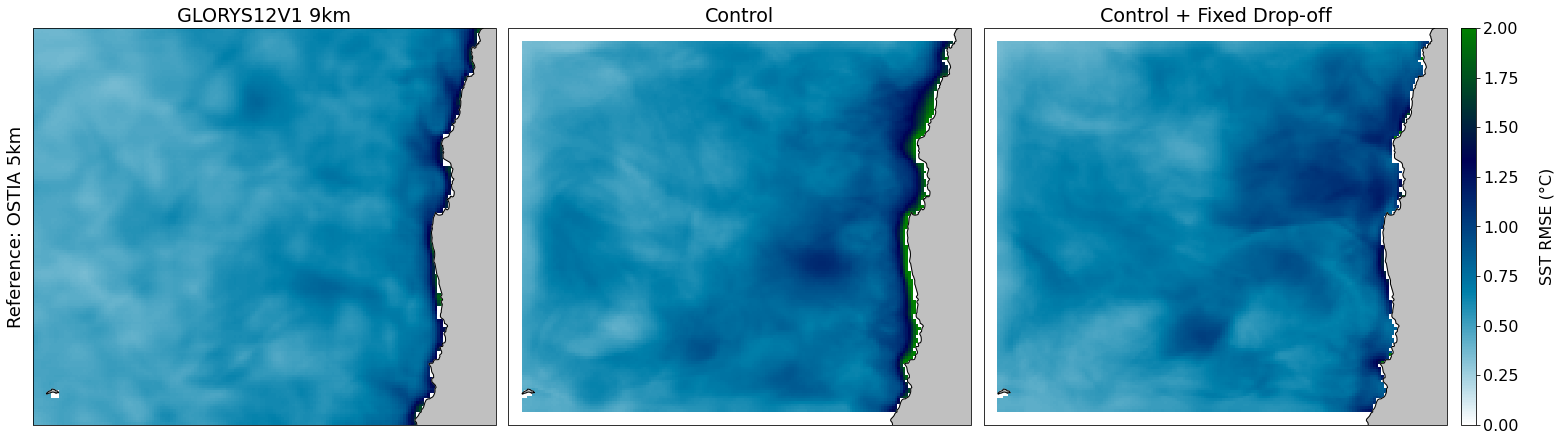

In [11]:
fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
fig.tight_layout(pad=0.8)
titles    = ['GLORYS12V1 9km','Control','Control + Fixed Drop-off']
plt.rc('font', size=16)
for i,axis in enumerate(ax):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines(zorder=3)
    axis.add_feature(cf.LAND, zorder=2, color='silver')
    axis.set_title(titles[i])
ax[0].set_yticks([])
ax[0].set_ylabel('Reference: OSTIA 5km', fontsize=18)
box = ax[-1].get_position()
cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

cmap='ocean_r'
norm=mcolors.Normalize(0,2)
m=ax[0].pcolormesh(glorys_bias.lon,glorys_bias.lat, (glorys_bias**2).mean('time')**0.5, rasterized=True, cmap=cmap, norm=norm)
m=ax[1].pcolormesh(testsim_control_bias.lon,testsim_control_bias.lat, (testsim_control_bias**2).mean('time')**0.5, rasterized=True, cmap=cmap, norm=norm)
m=ax[2].pcolormesh(testsim_BLKNOMASK_bias.lon,testsim_BLKNOMASK_bias.lat, (testsim_BLKNOMASK_bias**2).mean('time')**0.5, rasterized=True, cmap=cmap, norm=norm)
# ax[1].pcolormesh(ncchile_bias.lon,ncchile_bias.lat, ncchile_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
# ax[2].pcolormesh(simulation_bias.lon,simulation_bias.lat, simulation_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
fig.colorbar(m,cax=cax, label='\nSST RMSE (°C)')

/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/ceaza/lucas/miniconda3/envs/main/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


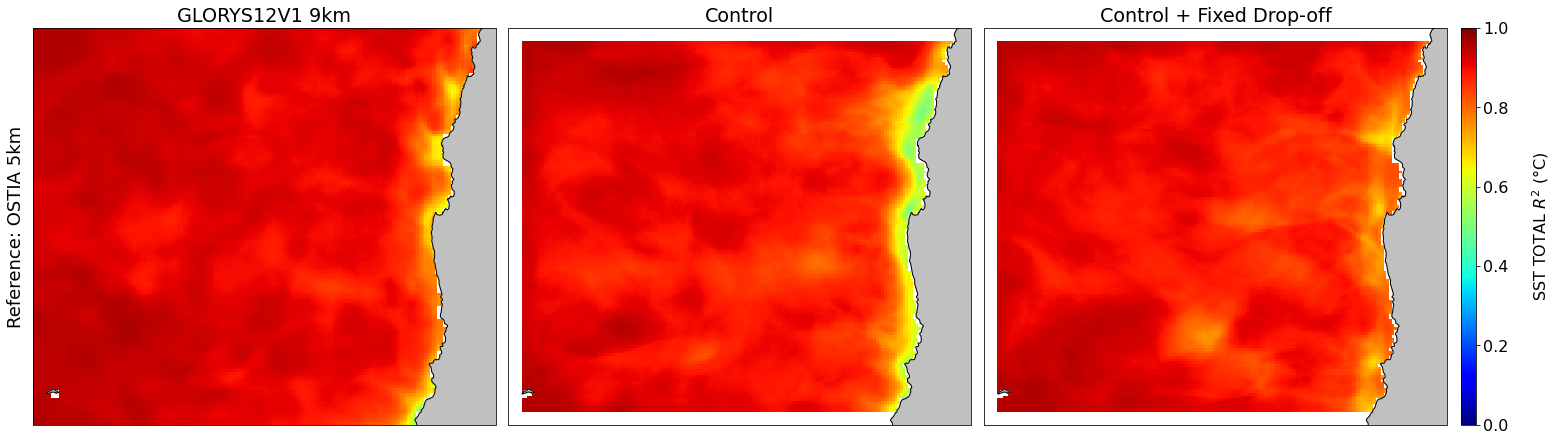

In [12]:
fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
fig.tight_layout(pad=0.8)
titles    = ['GLORYS12V1 9km','Control','Control + Fixed Drop-off']
plt.rc('font', size=16)
for i,axis in enumerate(ax):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines(zorder=3)
    axis.add_feature(cf.LAND, zorder=2, color='silver')
    axis.set_title(titles[i])
ax[0].set_yticks([])
ax[0].set_ylabel('Reference: OSTIA 5km', fontsize=18)
box = ax[-1].get_position()
cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

cmap='jet'
norm=mcolors.Normalize(0,1)
m=ax[1].pcolormesh(testsim_control_bias.lon,testsim_control_bias.lat, testsim_control_corr**2, rasterized=True, cmap=cmap, norm=norm)
m=ax[0].pcolormesh(glorys_bias.lon,glorys_bias.lat, glorys_corr**2, rasterized=True, cmap=cmap, norm=norm)
m=ax[2].pcolormesh(testsim_BLKNOMASK_bias.lon,testsim_BLKNOMASK_bias.lat, testsim_BLKNOMASK_corr**2, rasterized=True, cmap=cmap, norm=norm)
# ax[1].pcolormesh(ncchile_bias.lon,ncchile_bias.lat, ncchile_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
# ax[2].pcolormesh(simulation_bias.lon,simulation_bias.lat, simulation_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
fig.colorbar(m,cax=cax, label='\nSST TOTAL $R^2$ (°C)')

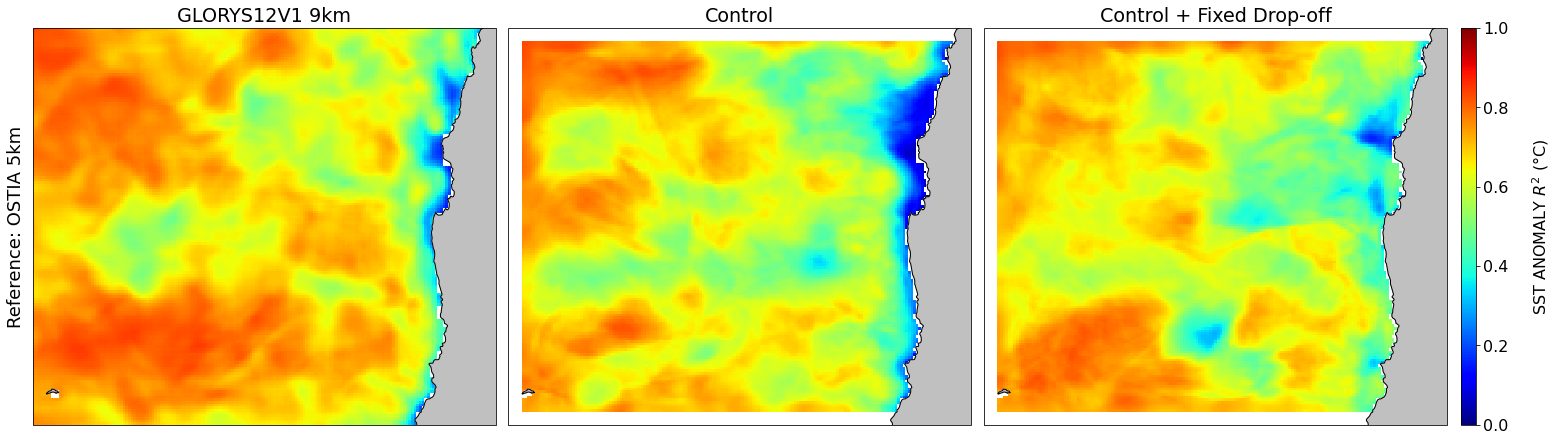

In [13]:
fig, ax = plt.subplots(1,3, figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree()}, sharex=True, sharey=True)
fig.tight_layout(pad=0.8)
titles    = ['GLORYS12V1 9km','Control','Control + Fixed Drop-off']
plt.rc('font', size=16)
for i,axis in enumerate(ax):
    axis.set_extent([-79.25,-70.5,-34.25,-26.75])
    axis.coastlines(zorder=3)
    axis.add_feature(cf.LAND, zorder=2, color='silver')
    axis.set_title(titles[i])
ax[0].set_yticks([])
ax[0].set_ylabel('Reference: OSTIA 5km', fontsize=18)
box = ax[-1].get_position()
cax = fig.add_axes([box.xmax*1.01,box.ymin,0.01,box.ymax-box.ymin])

cmap='jet'
norm=mcolors.Normalize(0,1)
m=ax[1].pcolormesh(testsim_control_bias.lon,testsim_control_bias.lat, testsim_control_acorr**2, rasterized=True, cmap=cmap, norm=norm)
m=ax[0].pcolormesh(glorys_bias.lon,glorys_bias.lat, glorys_acorr**2, rasterized=True, cmap=cmap, norm=norm)
m=ax[2].pcolormesh(testsim_BLKNOMASK_bias.lon,testsim_BLKNOMASK_bias.lat, testsim_BLKNOMASK_acorr**2, rasterized=True, cmap=cmap, norm=norm)
# ax[1].pcolormesh(ncchile_bias.lon,ncchile_bias.lat, ncchile_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
# ax[2].pcolormesh(simulation_bias.lon,simulation_bias.lat, simulation_bias.mean('time'), rasterized=True, cmap=cmap, norm=norm)
fig.colorbar(m,cax=cax, label='\nSST ANOMALY $R^2$ (°C)')

In [14]:
with ProgressBar():
    mask = regionmask.mask_geopandas(coastmask, reference.lon, reference.lat)
    mask = mask==0
    mask = ((~np.isnan(reference.sst[0])) & mask).load()
    mask[:85]  = 0
    mask[-55:] = 0
    
    reference_coast            = ostia['sst'].where(mask==1).mean(['lat','lon']).to_series()
    testsim_control_bias_coast = testsim_control_bias.where(mask==1).mean(['lat','lon']).to_series()
    glorys_bias_coast      = glorys_bias.where(mask==1).mean(['lat','lon']).to_series()
    testsim_BLKNOMASK_bias_coast      = testsim_BLKNOMASK_bias.where(mask==1).mean(['lat','lon']).to_series()

[########################################] | 100% Completed | 105.53 ms
[########################################] | 100% Completed | 26.06 s
[########################################] | 100% Completed | 53.03 s


Text(0.0, 1.0, '29.86S 71.55W (Coquimbo Bay) sea surface temperature')

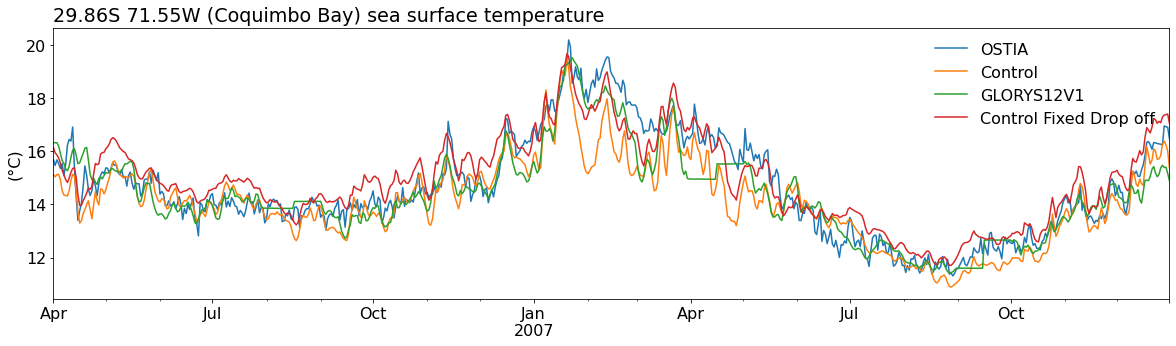

In [36]:
#Plot coast averages time series for each model

fig = plt.figure(figsize=(20,5))
reference_coast.plot(label='OSTIA')
(reference_coast+testsim_control_bias_coast).plot(label='Control')
(reference_coast+glorys_bias_coast).plot(label='GLORYS12V1')
(reference_coast+testsim_BLKNOMASK_bias_coast).plot(label='Control Fixed Drop off')

# plt.axvspan("2006-12","2007-06", color='grey', alpha=0.2, label='Biased')

plt.legend(ncol=1, loc='upper right', frameon=False)
plt.xlabel("")
plt.ylabel("(°C)")
plt.title("29.86S 71.55W (Coquimbo Bay) sea surface temperature", loc='left')


In [16]:
from scipy.stats import pearsonr
statistics = pd.DataFrame([], index=['Control','GLORYS12V1','Control Fixed Drop off'], columns=['MBIAS','RMSE','R2'])
statistics['MBIAS'] = [x.mean() for x in [testsim_control_bias_coast, glorys_bias_coast, testsim_BLKNOMASK_bias_coast]]
statistics['RMSE']  = [(x**2).mean()**0.5 for x in [testsim_control_bias_coast, glorys_bias_coast, testsim_BLKNOMASK_bias_coast]]
statistics['R2']    = [pearsonr(x+reference_coast, reference_coast)[0]**2 for x in [testsim_control_bias_coast, glorys_bias_coast, testsim_BLKNOMASK_bias_coast]]
statistics

,MBIAS,RMSE,R2
Control,-0.496478,0.953435,0.816989
GLORYS12V1,-0.259281,0.727867,0.871234
Control Fixed Drop off,0.289193,0.717620,0.881763
